jupyter nbconvert HKcourse4.ipynb --to slides --post serve

# Some Facets of Information Theoretical Graph Analytics

F. Oggier (School of Physical and Mathematical Sciences, NTU, Singapore) 

CSCIT 2019, CUHK

###  Centralities and Entropic Centralities

### Random Graphs and Power Law

### Information Theoretic Clustering

### A Case Study: Bitcoin Forensics

## Information Theoretic Clustering
### Graph Data

For clustering general data, we saw data points in $\mathbb{R}^d$. Can't we do the same things for a graph (a simple graph $G=(V,E)$)?

To do clustering in $\mathbb{R}^d$, we typically use the Euclidean distance, or at least *some distance*.

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
<ol>
<li> non-negativity: $d(x,y) \geq 0$.  </li> 
<li> identity of indiscernibles: $d(x,y)=0 \iff x=y$.    </li>
<li> symmetry: $d(x,y) = d(y,x)$. </li>
<li> The triangle inequality holds: $d(x,z)\leq d(x,y)+d(y,z)$.</li>
</ol>
</div>

If 2. is removed, we speak of pseudo-metrics/distance. If 3. is removed, we speak of quasi-metrics/distance.

Given an undirected (connected) graph, the length of a shortest path between two nodes is an actual distance. 
So if we could map any vertex $v\in V$ to a point ${\bf x}_v\in\mathbb{R}^d$, so that the length of a shortest path between $u,v$ is the same as $||{\bf x}_u-{\bf x}_v||^2$, then we could just embed $G$ into $\mathbb{R}^d$ and cluster the graph there.

This is called an **isometric graph embedding**. 

This certainly is not possible all the time (Deza and Laurent, "Geometry of Cuts and Metrics").

The problem becomes more interesting if we allow a distorsion.

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
Given these two metric spaces $(V,\rho)$ and $(\mathbb{R}^d,l_2)$, 
a function $f:V \rightarrow \mathbb{R}^d$ is called a $D$-embedding if 
for all $u,v \in V$, 
$r \rho(u,v) \leq ||f(u)-f(v)|| \leq D r \rho(u,v)$
where $r >0$ is a scaling factor. 
</div>

(Bourgain 85) Every $N$-point metric space $(X,\rho)$ (and thus in particular a graph with $N$ vertices) can be embedded into a Euclidean space with norm $l_2$ (the original work used the $l_1$ norm) with a distorsion of $O(\log N)$. This distorsion is known to be tight, since some expander graphs are reaching it. 

* Many works to refine the embbeding and to find the lowest dimension $d$ (Matousek, "Lectures on Discrete Geometry").

* Johnson-Lindenstrauss Lemma for dimensionality reduction.

A computational embedding can be obtained using semidefinite programming: 

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
\begin{eqnarray*}
\min & {\rm tr}(CX) \\
s.t. & {\rm tr}(A_iX) \leq b_i,~i=1,\ldots,m \\
     & X \succeq {\bf 0}
\end{eqnarray*}
where $X,C,A_i$ are all symmetric $N\times N$ matrices and $X \succeq {\bf 0}$ means that $X$ is positive semidefinite (that is, satisfies that ${\bf a}^TX{\bf a} \geq 0$ for any column vector ${\bf a}$).
</div>

Consider the $N\times N$ matrix $F$ whose columns are the embeddings $f(v_1),\ldots,f(v_N)$. Then
$X=F^TF$ has coefficients $x_{ij}=\langle f(v_i),f(v_j)\rangle$ and is positive semidefinite. To have a $D$-embedding into $\mathbb{R}^N$, we need for all $v_i,v_j\in V$:
\begin{eqnarray*}
&& \rho(v_i,v_j)^2 \leq ||f(v_i)-f(v_j)||^2 \leq D^2 \rho(v_i,v_j)^2 \\
&\iff& \rho(v_i,v_j)^2 \leq x_{ii}+x_{jj}-2x_{ij} \leq D^2 \rho(v_i,v_j)^2.
\end{eqnarray*}
Therefore, for ${\bf d}$ a vector of norm $D$, that is such that $\langle {\bf d},{\bf d} \rangle =D^2$, we can formulate the problem of finding a $D$-embedding into $\mathbb{R}^N$ which minimizes $D$ as the following semidefinite program:
\begin{eqnarray*}
\min & \langle {\bf d},{\bf d} \rangle \\
s.t. & \rho(v_i,v_j)^2 \leq x_{ii}+x_{jj}-2x_{ij} \leq D^2 \rho(v_i,v_j)^2,~\forall i,j.
\end{eqnarray*}

This program optimizes $D$ given the dimension $N$ (therefore a higher dimensional embedding could give a smaller distorsion). 

[[0 1 2]
 [1 0 1]
 [2 1 0]]


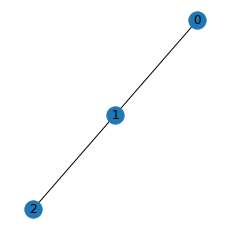

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

G = nx.Graph()
G.add_edges_from([(0,1),(1,2)])
all_paths = [x[1] for x in nx.all_pairs_shortest_path(G)]
N = G.order()
dist_list = []
for i in range(N):
    dist_list.append([len(all_paths[i][u])-1 for u in G.nodes()])
dist = np.matrix(dist_list)
print(dist)
fig = plt.figure(figsize=(3,3))
nx.draw(G,with_labels="true")
plt.show()

In [6]:
import cvxpy as cp, scipy.linalg
def embed_graph(N,dist):
    n = N+1
    C = np.zeros((n, n)) # Generate the objective function.
    C[n-1,n-1] = 1
    A = [] #Generate the constraints
    b = []
    for i in range(0,N):
        for j in range(i+1,N):
            M = np.zeros((n,n))
            M[i,i] = 1
            M[j,j] = 1
            M[i,j] = -1
            M[j,i] = -1
            A.append(M)
            b.append(dist[i,j]**2)
    for i in range(0,N):
        for j in range(i+1,N):
            M = np.zeros((n,n))
            M[i,i] = 1
            M[j,j] = 1
            M[i,j] = -1
            M[j,i] = -1
            M[N,N] = -dist[i,j]**2
            A.append(M)
            b.append(0.0)
    X = cp.Variable((n,n), symmetric=True)
    constraints = [X >> 0]
    constraints += [cp.trace(A[i]@X) >= b[i] for i in range(int(N*(N-1)/2))]
    constraints += [cp.trace(A[i]@X) <= b[i] for i in range(int(N*(N-1)/2),N*(N-1))]
    prob = cp.Problem(cp.Minimize(cp.trace(C@X)),constraints)
    L = np.linalg.cholesky(X.value)
    return(prob.value,L)

In [10]:
(D,L) = embed_graph(N,dist)
dist_l2 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        dist_l2[i,j] = np.linalg.norm(L[i,:]-L[j,:])
print(D)
print(L)
dist_l2

1.000000000002172
[[ 1.00000023e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.56290903e-07  6.75500220e-04  0.00000000e+00  0.00000000e+00]
 [-9.99999316e-01  1.35097158e-03  9.05137303e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


array([[0., 1., 2.],
       [1., 0., 1.],
       [2., 1., 0.]])

* So graphs typically cannot be embedded isometrically.

* $k$-means

* Let us try to apply the Renyi entropy based clustering algorithm on graph data .

1. Choose $C$ nodes uniformly at random, assign one label to each.
2. While some nodes are still unlabelled, for every cluster, find its neighbours.
3. If there are unlabelled neighbours or labelled neighbours with a worse distance to another cluster, add the neighbour whose addition minimizes the within-cluster evaluation function $\hat{H}_{\sigma^2}$.

![](209-emb2.png)

![](4k-2.png)

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
<b>Edge betweenness</b>: the betweenness of $e$ is the sum of the fraction of all-pairs shortest paths that pass through $e$. 
</div>    

The idea is that if a network contains clusters connected by a few edges, then all shortest paths between them must go along one of these few edges (and they are likely to have high edge betweenness). Removing these edges reveal the clusters. 

Girvan–Newman (02):

1. The betweenness of all existing edges is calculated.
2. The edge with the highest betweenness is removed.
3. The betweenness of all edges affected by the removal is recalculated.
4. Steps 2 and 3 are repeated until no edges remain.

Let $C=\cup C_i$ be the correct partition of the nodes, and $C' = \cup C'_j$ be another clustering. For every $C_i \in C$, compute the set $P_2(C_i)$ of all subsets of two elements of $C_i$, and similarly the set $P_2(C'_j)$ of all subsets of two elements of $C'_j$. Then for $P = \cup P_2(C_i)$ and $P' = \cup P_2(C'_j)$:
<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
the <b>F-score</b> of $C'$ with respect to $C$ is defined by
$\frac{2|P\cap P'|}{2|P\cap P'|+|P- P'|+|P'- P|}$.
</div>    

An $F$-score of 1 means a perfect match. The closer to 1, the best an $F$-score is.


**Modularity** (Newman 04,06) 

Given a clustering, modularity measures the number of edges that lie within a cluster compared to the expected number of edges of a  random  graph  with  the  same  degree  distribution (random  graphs  are  not  expected  to  have *community*  structure).  

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
$    
\frac{1}{2|E|}\sum_{i,j}[A_{ij}−\frac{k_ik_j}{2|E|}\delta(c_i,c_j)]
$
</div>    
where $A$ is the adjacency matrix (the graph is unweighted), $\delta(c_i,c_j) = 1$ if nodes $i,j$ belong to the same community and 0 otherwise. It can be either positive or negative. Higher positive values indicate better community structure properties.

**Louvain** (Blondel 08): Find the clustering that maximizes the modularity. 

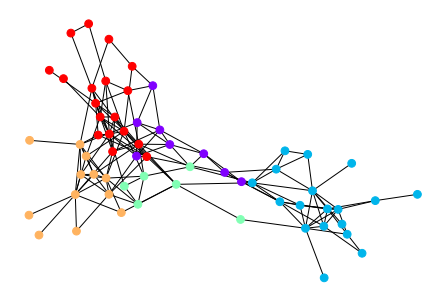

In [29]:
#pip install python-louvain, https://python-louvain.readthedocs.io/en/latest/
import community
Gdolph = nx.read_gml('dolphins.gml', label = 'id')
partition = community.best_partition(Gdolph)
part_label = [partition[u] for u in partition]
val_map = {}
for k in range(0,Gdolph.order()):
    val_map[k] = part_label[k]
values = [val_map.get(node, 0) for node in Gdolph.nodes()]
nx.draw(Gdolph,cmap=plt.get_cmap('rainbow'), node_color=values,node_size=60)
plt.show()

What happens if the graph is directed?

* treat the graph as undirected? encode directionality in weights? bipartite graphs?
* embedding poses the problem of *distance*, which distance?
* extend clustering evaluation functions?

<div style="background-color:rgba(128, 0, 0, 0.1); text-align:left; vertical-align: middle; padding:20px 0;">
$    
\frac{1}{|E|}\sum_{i,j}[A_{ij}−\frac{k_i^{out}k_j^{in}}{2|E|}\delta(c_i,c_j)].
$
</div>    

* citation-based clusters

* flow-based clusters

* Yamada, Saito, Ueda, Cross-Entropy Directed Embedding of Network Data, 03.

Rosvall and Bergstrom (08)

* use random walks to describe information flow in the network. 
* extract the clusters by compressing the description of the random walk.  
* in a cluster, the random walk can be compressed better.

This becomes a coding problem: select a clustering of the nodes, which minimizes the description length of the random walk.

* Each node is given a Huffman codeword based on the visiting frequency of the  random  walk (in an infinitely long walk): shorter codewords  are  assigned  to  more  frequently  visited nodes.

* The interest is not in the codewords themselves but rather in the theoretical limit of how concisely we can specify the path.

* The random walk trajectory is described by a two-level description: unique names (codewords) are assigned to the clusters (coarse-grain), while the codewords for nodes inside a cluster are reused (fine-grain).  

* Analogy with a geographic map:  unique names are assigned to cities (clusters), while names for the streets (nodes) can be reused.  

* When the random walker enters a cluster, use the codeword for this cluster, then use use codewords within, and then an exit code when going out of the cluster.

* The clustering problem becomes finding the partition that results in the minimum description code length (minimize a sum of two terms, the entropy of moving between clusters, and the sum of the entropies of moving within each).

Schaeffer, Graph clustering, Computer Science Review 

Malliarosa and Vazirgiannis, Clustering and Community Detection in Directed Networks:A Survey

Oggier, Phetsouvanh, Datta, Entropy-based Graph Clustering - A Simulated Annealing Approach, ISITA 2018